In [9]:
import sys
sys.path.append('../')

from train_utils import load_game_data, localize_file, initialize_model, get_loss
from files import list_files
from configs import GameConfig, NetworkConfig, TrainingConfig
import torch
import numpy as np
from tqdm import tqdm

game_config = GameConfig("../../configs/training/full_vast.toml")
network_config = NetworkConfig("../../configs/training/full_vast.toml")
training_config = TrainingConfig("../../configs/training/full_vast.toml")

In [35]:
gamedata_files = sorted(list_files("s3://alpha-blokus/full/games/", ".bin"))

total = 0
for gamedata_file in gamedata_files:
    total += int(gamedata_file.split("_")[-1].split(".")[0])
print(total)

selected_files = [
    gamedata_files[-1],
    gamedata_files[-3],
    gamedata_files[-5],
    gamedata_files[-7],
    gamedata_files[-9],
    gamedata_files[-11]
]

4628491


In [37]:
dataloader = load_game_data(game_config, 128, 
    # [
    #     localize_file("s3://alpha-blokus/full/games/2025-11-19_14-01-09-136298776-42434854_10002.bin"),
    #     localize_file("s3://alpha-blokus/full/games/2025-11-19_14-21-18-996485409-33490187_10000.bin"),
    #     localize_file("s3://alpha-blokus/full/games/2025-11-19_14-41-35-618075183-33582482_10000.bin"),
    #     localize_file("s3://alpha-blokus/full/games/2025-11-19_14-50-36-882689353-95060964_10015.bin"),
    #     localize_file("s3://alpha-blokus/full/games/2025-11-19_14-55-07-298816558-72977861_10000.bin"),
    #     localize_file("s3://alpha-blokus/full/games/2025-11-19_14-57-16-887018913-04608283_10006.bin"),
    # ],
    [localize_file(f) for f in selected_files],
    int(1e6))

In [38]:
model_files = list_files("s3://alpha-blokus/full/training/", ".pth")
model_files = [m for m in model_files if m > "s3://alpha-blokus/full/training/03000000.pth"]

In [39]:
def compute_losses_on_dataset(model_path: str):
    model_local_path = localize_file(model_path)

    model = initialize_model(network_config, game_config)
    model.load_state_dict(torch.load(model_local_path)["model"])
    model.to(device=training_config.device)
    print("Done loading model.")

    total_losses = []
    value_losses = []
    policy_losses = []
    for batch in tqdm(dataloader):
        total_loss, value_loss, policy_loss = get_loss(batch, training_config, model)
        total_losses.append(total_loss.item())
        value_losses.append(value_loss.item())
        policy_losses.append(policy_loss.item())

    return (
        np.mean(np.array(total_losses)),
        np.mean(np.array(policy_losses)),
        np.mean(np.array(value_losses)),
    )

number_of_models = len(model_files)
print("Number of models:", number_of_models)
number_of_data_points = 10

sample_counts = []
total_losses = []
policy_losses = []
value_losses = []

for i in tqdm(range(number_of_data_points)):
    model_index = round(i * (number_of_models - 1) / (number_of_data_points - 1))
    model_path = model_files[model_index]

    total_loss, policy_loss, value_loss = compute_losses_on_dataset(model_path)

    sample_counts.append(int(model_path.split("/")[-1].split(".")[0]))
    total_losses.append(total_loss)
    policy_losses.append(policy_loss)
    value_losses.append(value_loss)

Number of models: 81


  0%|          | 0/10 [00:00<?, ?it/s]

Done loading model.


 10%|█         | 1/10 [00:22<03:24, 22.78s/it]

Done loading model.


 20%|██        | 2/10 [00:44<02:55, 21.91s/it]

Done loading model.


 30%|███       | 3/10 [01:03<02:26, 20.87s/it]

Done loading model.


 40%|████      | 4/10 [01:23<02:01, 20.31s/it]

Done loading model.


 50%|█████     | 5/10 [01:42<01:40, 20.04s/it]

Done loading model.


 60%|██████    | 6/10 [02:02<01:20, 20.02s/it]

Done loading model.


 70%|███████   | 7/10 [02:22<01:00, 20.08s/it]

Done loading model.


 80%|████████  | 8/10 [02:44<00:41, 20.70s/it]

Done loading model.


 90%|█████████ | 9/10 [03:06<00:21, 21.06s/it]

Done loading model.


100%|██████████| 10/10 [03:26<00:00, 20.68s/it]


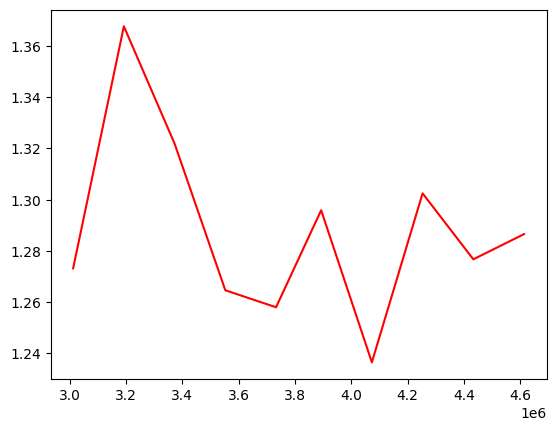

In [47]:
import matplotlib.pyplot as plt

# plt.plot(sample_counts, total_losses, color="blue")
# plt.plot(sample_counts, policy_losses, color="green")
plt.plot(sample_counts, value_losses, color="red")
plt.show()


In [ ]:
# 04613343

1.9289397026684239
0.6459930054922857
1.2829466903133433


# 04213034
1.8178169610403747
0.6427565932528042
1.1750603698209914

# 03032222
1.9070150976750389
0.6581721876475857
1.2488429109170747


  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Note: you may need to restart the kernel to use updated packages.
